# **RÉGRESSION LOGISTIQUE MULTIVARIÉE REGULARISÉE POUR CLASSIFICATION CHIEN/CHAT**

Dans ce script, nous implémentons la régression logistique régularisée à la main afin de faire la classification chien/chat.

Nous avons des images de chiens et de chats dans notre ensemble d'entrainement et de test. Il y a autant d'exemples de chien que de chats, nos classes ne sont pas débalancées.

Ces images seront prétraitées, mises en un seul vecteur par exemple afin d'obtenir une matrice contenant l'ensemble des pixels pour un exemple sur la même ligne.

La normalisation min-max interviendra afin d'avoir des valeurs entre 0 et 1 et faciliter la convergence.

La régularisation sera aussi ajoutée afin de contrôler le sur-apprentissage.

# **IMPORTATION DES BIBLIOTHÈQUES NECESSAIRES**

In [353]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import h5py

# **ETAPE 1: CHARGEMENT ET VISUALISATION DES DONNÉES**

# **FONCTION POUR CHARGER LES DONNÉES**

La fonction load_data permet de charger nos données et retourne

X_train: Données d'entrainement contenant 1000 images 64*64 de chiens et de chats. (500 pour chacun)

Y_train: Les étiquettes pour chaque exemple du X_train

X_test: Données de test contenant 200 images 64*64 de chiens et de chats. (100 pour chacun)

Y_test: Les étiquettes pour chaque exemple du X_test

In [330]:
def load_data():
  train_set = h5py.File("trainset.hdf5", 'r')
  test_set = h5py.File("testset.hdf5", 'r')

  X_train = np.array(train_set["X_train"][:])
  Y_train = np.array(train_set["Y_train"][:])
  X_test = np.array(test_set["X_test"][:])
  Y_test = np.array(test_set["Y_test"][:])

  return X_train, Y_train, X_test, Y_test

In [331]:
X_train, Y_train, X_test, Y_test = load_data()

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1000, 64, 64)
(1000, 1)
(200, 64, 64)
(200, 1)


# **DÉFINITION D'UNE FONCTION POUR AFFICHER 10 EXEMPLES DE L'ENSEMBLE D'ENTRAINEMENT ET DE TEST**

In [332]:
def display_images(X_train, X_test):
  for name, X in [("X_train", X_train), ("X_test", X_test)]:
    plt.figure(figsize = (12, 8))
    plt.axis("off")
    plt.title(name + " 10 exemples")
    for i in range(10):
      plt.subplot(2, 5, i + 1)
      plt.imshow(X[i], cmap = "gray")
      plt.axis("off")


    plt.show()

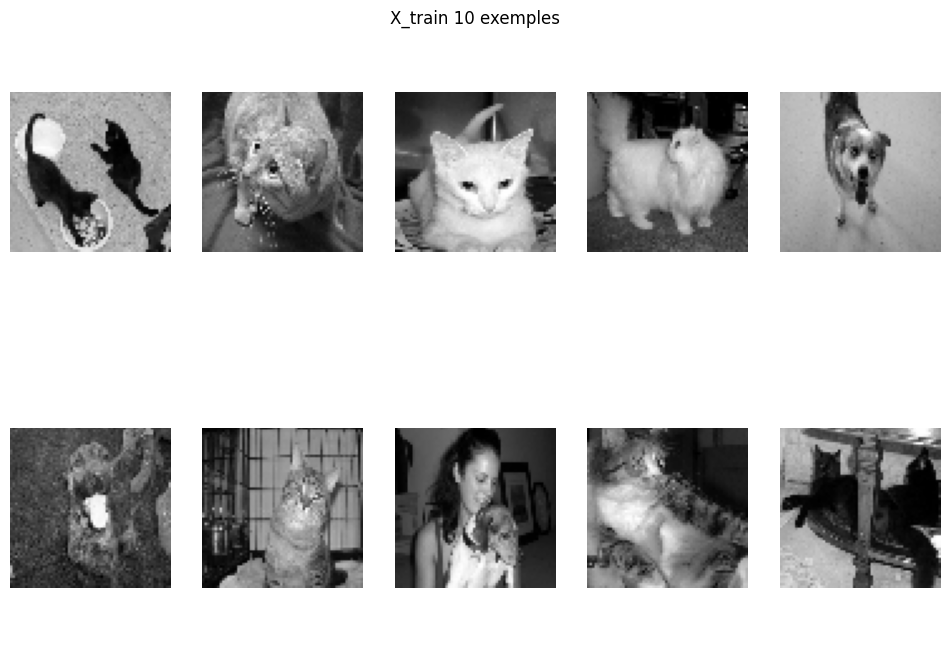

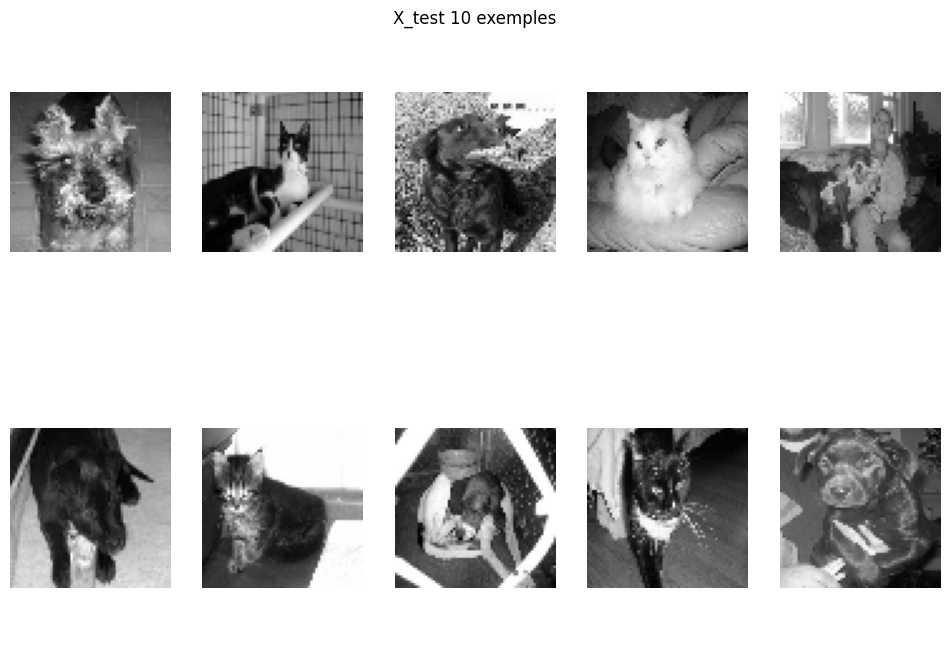

In [333]:
display_images(X_train, X_test)

# **ETAPE 2: PRÉTRAITEMENT DES DONNÉES**

Dans cette étape, nous effectuerons deux traitements

1 - Applatir X_train et X_test: Pour l'instant X_train est de dimesnion (1000, 64, 64), autrement dit, c'est un tableau de 1000 matrices 64X64, chaque matrice représentant une image de chien ou de chat.
X_test lui est de dimension (200, 64, 64), il contient donc 200 matrices 64X64 représentant des chiens et des chats.
Nous allons applatir chaque matrice 64X64 contenue dans X_train et X_test en un vecteur de 4096 éléments, afin d'avoir une matrice (1000, 4096) pour X_train et (200, 4096) pour X_test ce qui facilitera nos opérations

2 - Normaliser X_train et X_test: Après avoir applati, nous allons normaliser, les 4096 colonnes de X_train et X_test en utilisant ce qu'on appelle la min-max normalisation, pour chaque colonne Xi, nous ferons l'opération suivante: Xi = (Xi - Xi min) / (Xi max - Xi min).
Nous passons de valeurs dans l'intervalle [0, 255] à des valeurs dans l'intervalle [0, 1] ce qui est bien meilleur pour la convergence.

# **FONCTION POUR APPLATIR LES ENTRÉES**

In [334]:
def Flatten(X_train, X_test):
  X_train_flattened = np.array([X_train[i].flatten() for i in range(X_train.shape[0])])
  X_test_flattened = np.array([X_test[i].flatten() for i in range(X_test.shape[0])])

  return X_train_flattened, X_test_flattened

# **FONCTION POUR NORMALISER**

In [335]:
def min_max_normalisation(X_train, X_test):
  min = X_train.min(axis = 0)
  max = X_train.max(axis = 0)

  eps = 1e-15
  X_train = (X_train - min) / (max - min + eps) # Pour éviter une potentielle division par zéro
  X_test = (X_test - min) / (max - min + eps) # Pour éviter une potentielle division par zéro

  return X_train, X_test

In [336]:
X_train_flattened, X_test_flattened = Flatten(X_train, X_test)

print(X_train_flattened.shape)
print(X_train_flattened[:5])
print("\n")
print(X_test_flattened.shape)
print(X_test_flattened[:5])

(1000, 4096)
[[164 174 163 ...  87 180  39]
 [ 42  43  39 ...  55  52  55]
 [ 27  26  29 ... 135 141 121]
 [ 77  26  54 ...  60  69  59]
 [173 182 178 ... 141 135 139]]


(200, 4096)
[[ 47  47  51 ... 155 156 154]
 [130 148 125 ... 114  77 117]
 [216 133 200 ... 193 166 177]
 [  9  27  27 ...  80  72  61]
 [250 250 196 ...  21  24  45]]


In [337]:
X_train_flattened_norm, X_test_flattened_norm = min_max_normalisation(X_train_flattened, X_test_flattened)

print(X_train_flattened_norm.shape)
print(X_train_flattened_norm[:5])
print("\n")
print(X_test_flattened_norm.shape)
print(X_test_flattened_norm[:5])


(1000, 4096)
[[0.64566929 0.68503937 0.64173228 ... 0.34251969 0.70866142 0.15354331]
 [0.16535433 0.16929134 0.15354331 ... 0.21653543 0.20472441 0.21653543]
 [0.10629921 0.1023622  0.11417323 ... 0.53149606 0.55511811 0.47637795]
 [0.30314961 0.1023622  0.21259843 ... 0.23622047 0.27165354 0.23228346]
 [0.68110236 0.71653543 0.7007874  ... 0.55511811 0.53149606 0.54724409]]


(200, 4096)
[[0.18503937 0.18503937 0.2007874  ... 0.61023622 0.61417323 0.60629921]
 [0.51181102 0.58267717 0.49212598 ... 0.4488189  0.30314961 0.46062992]
 [0.8503937  0.52362205 0.78740157 ... 0.75984252 0.65354331 0.69685039]
 [0.03543307 0.10629921 0.10629921 ... 0.31496063 0.28346457 0.24015748]
 [0.98425197 0.98425197 0.77165354 ... 0.08267717 0.09448819 0.17716535]]


# **ETAPE 3: DÉFINITION DES DIFFÉRENTES FONCTIONS POUR LA REGRESSION LOGISTIQUE RÉGULARISÉE**

Dans cette étape, après avoir chargé, visualisé et prétraité nos données, nous pouvons enfin implémenter les différentes fonctions pour notre régression logistique.

Nous aurons les fonctions suivantes:
- init: Fonction pour charger les paramètres du modèle

- Hypothesis: Fonction de calcul d'hypothèse, qui est la sigmoide et qui nous retournera des probabiltés d'appartenance à la classe 1 pour chaque exemple.

- log_loss: Fonction de calcul du coût qui nous permettra de voir l'évolution du coût(erreur) du modèle à chaque itération.

- update_weights: Cette fonction nous permettra de calculer les gradients pour chaque paramètre du modèle et de mettre à jour les poids à chaque itération afin de se diriger vers la diminution du coût.

- gradient_descent: Cette fonction effectue la desecente de gradient en itérant un nombre de fois et en effectuant à chaque itération les étapes suivantes:
  - Calcul de l'hypotèse avec les poids courant avec la fonction
    hypothesis.
  - Calcul du cout pour l'itération courante avec la fonction regularized_log_loss.
  - Mise à jours des paramètres du modèles avec la fonction update_weights.

La fonction init sera appelée avant de commencer la desecnte de gradient afin de fixer un point de départ pour nos paramètres.

In [338]:
def init(X):
  np.random.seed(42)
  weights = np.random.randn(X.shape[1], 1)
  bias = np.random.randn(1)

  return weights, bias

In [339]:
def hypothesis(X, weights, bias):
  Z = np.dot(X, weights) + bias
  Z = np.clip(Z, -500, 500) # Pour éviter un overflow silencieux
  return 1 / (1 + np.exp(-Z))
  print("World")

In [340]:
def regularized_log_loss(H, Y, weights, reg_value):
  eps = 1e-15
  H = np.clip(H, eps, 1 - eps)
  L = (-1 / H.shape[0]) * (np.sum(Y * np.log(H) + (1 - Y) * np.log(1 - H))) # classic loss
  R = (reg_value / (2 * H.shape[0])) * (np.sum(np.square(weights))) # regularisation term
  return L + R

In [341]:
def update_weights(X, Y, H, weights, bias, learning_rate, reg_value):
  dw = ((1 / X.shape[0]) * np.dot(X.T, (H - Y))) + ((reg_value / X.shape[0]) * weights)
  db = (1 / X.shape[0]) * (np.sum(H - Y))

  weights = weights - learning_rate * dw
  bias = bias - learning_rate * db

  return weights, bias

In [342]:
def gradient_descent(X, Y, learning_rate = 0.01, reg_value = 0.01, n_iterations = 100):
  weights, bias = init(X)
  loss_history = []

  for i in range(n_iterations):
    H = hypothesis(X, weights, bias)
    loss_history.append(regularized_log_loss(H, Y, weights, reg_value))
    weights, bias = update_weights(X, Y, H, weights, bias, learning_rate, reg_value)

  return weights, bias, loss_history

# **ETAPE 4: RECHERCHE DES MEILLEURS HYPERPARAMÈTRES ET VISUALISATION DES RESULTATS**

Dans cette étape, nous allons chercher les meilleurs hyperparamètres en se basant sur le coût sur l'entrainement.
Nous allons définir une plage de valeurs pour:
- Le pas d'apprentissage(learning_rate)
- Le terme de régularisation(lambda)
- Le nombre d'itérations

Nous effectuerons une descente de gradient pour chaque combinaison (learning_rate, reg_value, n_iterations) et garderons les paramètres de la combinaison minimisant le coût sur l'ensemble d'entrainement.

Nous visualiserons également différents resultats tels que la courbe de coût de la meilleure combinaison qu'on gardera en mémoire afin de voir son évolution et de s'assurer que la déscente de gradient se passe bien ou encore les performances du modèle sur l'ensemble d'entrainement et de test en affichant la matrice de confusion, le rapport de classification, le MAE, MSE et l'exactitude.

# **FONCTION DE PRÉDICTION**

In [343]:
def predict(X, weights, bias):
  H = hypothesis(X, weights, bias)
  return (H >= 0.5).reshape(-1, 1)

# **FONCTION DE RECHERCHE DES MEILLEURS HYPERPARAMÈTRES**

In [347]:
def find_best_hyperparameters(X_train, Y_train, X_test, Y_test, learning_rates, reg_values, n_iterations_values):
  best_hyperparameters = {
      "weights" : None,
      "bias" : None,
      "learning_rate" : None,
      "reg_value" : None,
      "n_iterations" : None,
      "loss_history" : None,
      "accuracy" : -np.inf
  }
  i = 0
  for learning_rate in learning_rates:
    for reg_value in reg_values:
      for n_iterations in n_iterations_values:
        i += 1
        print(f"Combinaison {i} : ({learning_rate}, {reg_value}, {n_iterations})")
        weights, bias, loss_history = gradient_descent(X_train, Y_train, learning_rate, reg_value, n_iterations)
        Y_pred_test = predict(X_test, weights, bias)
        if accuracy_score(Y_test, Y_pred_test) > best_hyperparameters["accuracy"]:
          best_hyperparameters["weights"] = weights.copy()
          best_hyperparameters["bias"] = bias.copy()
          best_hyperparameters["learning_rate"] = learning_rate
          best_hyperparameters["reg_value"] = reg_value
          best_hyperparameters["n_iterations"] = n_iterations
          best_hyperparameters["loss_history"] = loss_history.copy()
          best_hyperparameters["accuracy"] = accuracy_score(Y_test, Y_pred_test)

  return best_hyperparameters

# **FONCTION POUR CALCULER DIFFÉRENTES MÉTRIQUES SUR L'ENSEMBLE D'ENTRAINEMENT ET DE TEST**

In [345]:
def compute_metrics(X_train, Y_train, X_test, Y_test, weights, bias):
  results = {
      "train" : {
          "mse" : None,
          "mae" : None,
          "accuracy" : None
      },
      "test" : {
          "mse" : None,
          "mae" : None,
          "accuracy" : None
      }
      }

  for name, X, Y in [("train", X_train, Y_train), ("test", X_test, Y_test)]:
    results[name]["mse"] = mean_squared_error(Y, hypothesis(X, weights, bias))
    results[name]["mae"] = mean_absolute_error(Y, hypothesis(X, weights, bias))
    results[name]["accuracy"] = accuracy_score(Y, predict(X, weights, bias))

  return results

In [350]:
learning_rates = [0.01, 0.02, 0.03, 0.04, 0.05]
reg_values = [1, 2, 3, 4, 5]
n_iterations_values = [1000, 2000, 3000, 4000, 5000]
best_hyperparameters = find_best_hyperparameters(X_train_flattened_norm, Y_train, X_test_flattened_norm, Y_test, learning_rates, reg_values, n_iterations_values)

for k, v in best_hyperparameters.items():
  if k != "loss_history":
    print(f"Meilleur {k} : {v}")

Combinaison 1 : (0.01, 1, 1000)
Combinaison 2 : (0.01, 1, 2000)
Combinaison 3 : (0.01, 1, 3000)
Combinaison 4 : (0.01, 1, 4000)
Combinaison 5 : (0.01, 1, 5000)
Combinaison 6 : (0.01, 2, 1000)
Combinaison 7 : (0.01, 2, 2000)
Combinaison 8 : (0.01, 2, 3000)
Combinaison 9 : (0.01, 2, 4000)
Combinaison 10 : (0.01, 2, 5000)
Combinaison 11 : (0.01, 3, 1000)
Combinaison 12 : (0.01, 3, 2000)
Combinaison 13 : (0.01, 3, 3000)
Combinaison 14 : (0.01, 3, 4000)
Combinaison 15 : (0.01, 3, 5000)
Combinaison 16 : (0.01, 4, 1000)
Combinaison 17 : (0.01, 4, 2000)
Combinaison 18 : (0.01, 4, 3000)
Combinaison 19 : (0.01, 4, 4000)
Combinaison 20 : (0.01, 4, 5000)
Combinaison 21 : (0.01, 5, 1000)
Combinaison 22 : (0.01, 5, 2000)
Combinaison 23 : (0.01, 5, 3000)
Combinaison 24 : (0.01, 5, 4000)
Combinaison 25 : (0.01, 5, 5000)
Combinaison 26 : (0.02, 1, 1000)
Combinaison 27 : (0.02, 1, 2000)
Combinaison 28 : (0.02, 1, 3000)
Combinaison 29 : (0.02, 1, 4000)
Combinaison 30 : (0.02, 1, 5000)
Combinaison 31 : (0

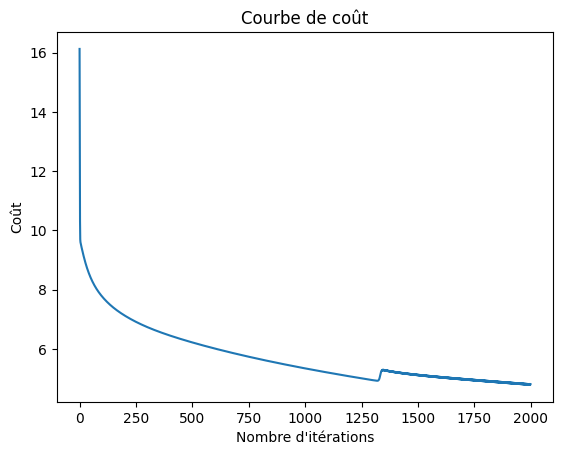

In [351]:
plt.plot(best_hyperparameters["loss_history"])
plt.xlabel("Nombre d'itérations")
plt.ylabel("Coût")
plt.title("Courbe de coût")
plt.show()

In [352]:
results = compute_metrics(X_train_flattened_norm, Y_train, X_test_flattened_norm, Y_test, best_hyperparameters["weights"], best_hyperparameters["bias"])
df_results = pd.DataFrame(results)
print(df_results)

             train      test
mse       0.343689  0.422831
mae       0.407197  0.473112
accuracy  0.593000  0.555000
